In [6]:
pip install tldextract

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse, parse_qs
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from tldextract import extract
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load data
df = pd.read_csv("/kaggle/input/phishing-site-urls/phishing_site_urls.csv")
df.columns = ['url', 'label']
df['label'] = df['label'].map({'bad': 1, 'good': 0})

In [9]:
# Enhanced feature extraction
def extract_features(url):
    try:
        parsed = urlparse(url)
        tsd, td, tsu = extract(url)  # Using tldextract for better domain parsing
        
        # Basic URL features
        features = {
            'url_length': len(url),
            'hostname_length': len(parsed.hostname) if parsed.hostname else 0,
            'path_length': len(parsed.path),
            'query_length': len(parsed.query),
            'fragment_length': len(parsed.fragment),
            'count_dot': url.count('.'),
            'count_hyphen': url.count('-'),
            'count_underline': url.count('_'),
            'count_slash': url.count('/'),
            'count_question': url.count('?'),
            'count_equal': url.count('='),
            'count_at': url.count('@'),
            'count_exclamation': url.count('!'),
            'count_space': url.count(' '),
            'count_percent': url.count('%'),
            'count_tilde': url.count('~'),
            'count_comma': url.count(','),
            'count_plus': url.count('+'),
            'count_star': url.count('*'),
            'count_colon': url.count(':'),
            'count_semicolon': url.count(';'),
            'count_dollar': url.count('$'),
            'count_hashtag': url.count('#'),
            'count_ampersand': url.count('&'),
            'count_digits': sum(c.isdigit() for c in url),
            'count_letters': sum(c.isalpha() for c in url),
            'count_other': len(url) - sum(c.isalnum() for c in url),
            'is_https': int(parsed.scheme == 'https'),
            'is_shortened': int(any(short in parsed.netloc for short in ['bit.ly', 'tinyurl', 'goo.gl'])),
            'has_ip': int(bool(re.match(r'\d+\.\d+\.\d+\.\d+', parsed.hostname or ''))),
            'has_port': int(parsed.port is not None),
            'num_subdomains': len(tsd.split('.')) if tsd else 0,
            'domain_token_count': len(td.split('.')) if td else 0,
            'path_token_count': len(parsed.path.split('/')) if parsed.path else 0,
            'query_param_count': len(parse_qs(parsed.query)) if parsed.query else 0,
            'avg_query_param_length': np.mean([len(p) for p in parse_qs(parsed.query).values()]) if parsed.query else 0,
            'tld_length': len(tsu) if tsu else 0,
            'is_tld_common': int(tsu in ['com', 'org', 'net', 'edu', 'gov']),
            'has_phishing_keywords': int(any(word in url.lower() for word in [
                'login', 'verify', 'secure', 'account', 'update', 'bank', 'signin',
                'confirm', 'password', 'webscr', 'ebayisapi', 'paypal', 'billing',
                'submit', 'security', 'validate', 'authentication', 'support',
                'alert', 'unlock', 'reset', 'identity', 'recovery', 'limited',
                'service', 'access', 'authorize', 'credentials', 'payment', 'urgent',
                'message', 'warning', 'win', 'free', 'bonus', 'click', 'verifyemail',
                'suspend', 'locked', 'danger', 'checkout', 'invoice', 'order'
            ])),
            'has_suspicious_tld': int(tsu in ['xyz', 'top', 'gq', 'tk', 'ml', 'cf', 'ga', 'pw']),
            'is_long_url': int(len(url) > 75),
            'is_highly_numeric': int(sum(c.isdigit() for c in url) / len(url) > 0.3 if url else 0)
        }
        
        # Entropy calculation for domain
        if parsed.hostname:
            freq = pd.Series(list(parsed.hostname)).value_counts(normalize=True)
            features['domain_entropy'] = -sum(freq * np.log2(freq))
        else:
            features['domain_entropy'] = 0
            
    except:
        features = {k:0 for k in features.keys()} if 'features' in locals() else None
    
    return features

In [10]:
# Extract features
print("Extracting features...")
features_df = df['url'].apply(extract_features).apply(pd.Series)

Extracting features...


In [11]:
# TF-IDF features
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=200,
    lowercase=True
)
tfidf_features = tfidf.fit_transform(df['url'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f"tfidf_{i}" for i in range(tfidf_features.shape[1])])

Creating TF-IDF features...


In [12]:
# Combine all features
print("Combining features...")
X = pd.concat([features_df, tfidf_df], axis=1)
y = df['label']

Combining features...


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Handle class imbalance using class weights
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [15]:
params = {
    'max_depth': randint(3, 8),                    
    'learning_rate': uniform(0.05, 0.2),           
    'n_estimators': randint(50, 200),              
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.3),
    'min_child_weight': randint(1, 6),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5)
}

In [16]:
# Use RandomizedSearchCV for more efficient search
print("Starting hyperparameter tuning...")
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    verbosity=1
)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=10,
    cv=3,
    scoring='f1',
    verbose=3,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

Starting hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a3d015cefd0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a3d0145b7d0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a3d0145ad90>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a3ce0219850>},
                   random_state=42, scoring='f1', verbose=3)

In [17]:
# Get best model
best_xgb = search.best_estimator_
print("\nBest parameters found:")
print(search.best_params_)

# Evaluate
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best parameters found:
{'colsample_bytree': 0.8123620356542087, 'gamma': 0.2852142919229748, 'learning_rate': 0.19639878836228103, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 152, 'reg_alpha': 0.22291637642679557, 'reg_lambda': 0.04998745790900144, 'subsample': 0.8377746675897602}

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     78585
           1       0.73      0.86      0.79     31285

    accuracy                           0.87    109870
   macro avg       0.84      0.87      0.85    109870
weighted avg       0.88      0.87      0.87    109870



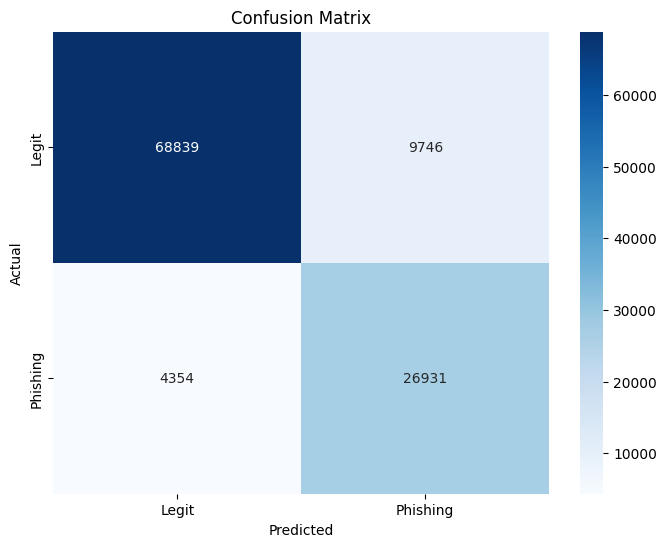

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Phishing'],
            yticklabels=['Legit', 'Phishing'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

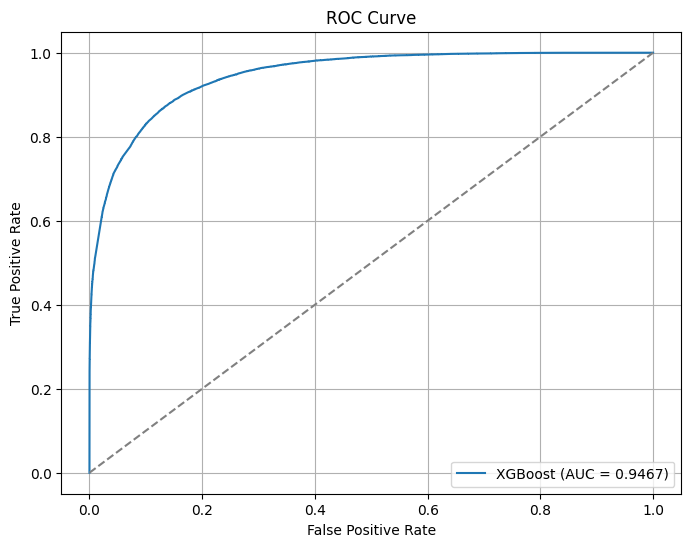

In [19]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

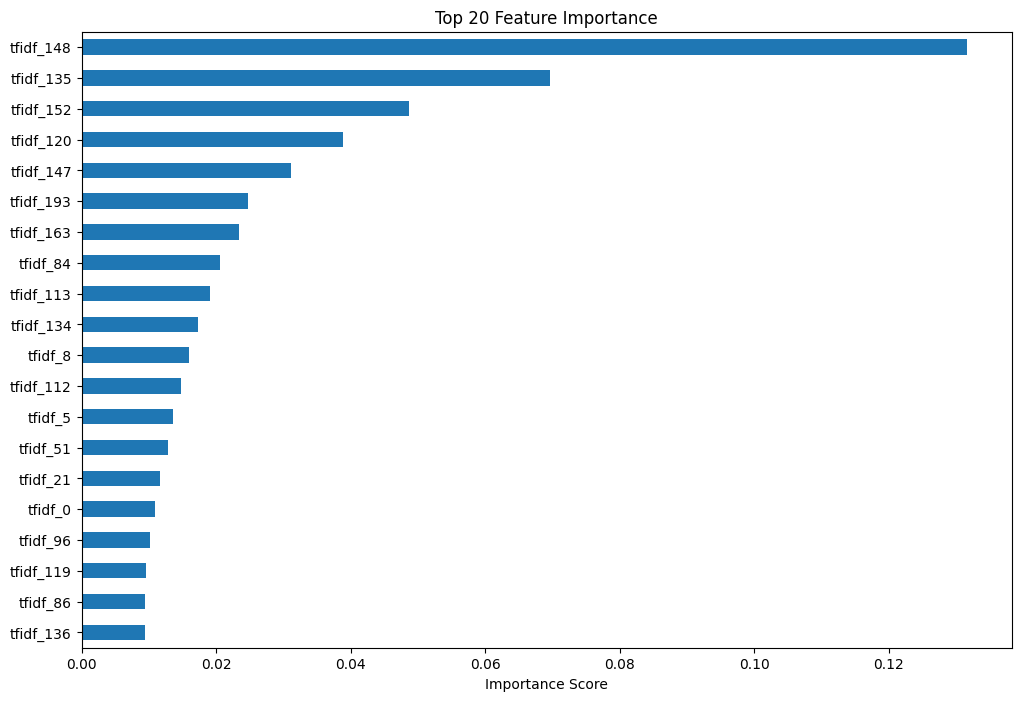


Model saved successfully!
[CV 3/3] END colsample_bytree=0.8123620356542087, gamma=0.2852142919229748, learning_rate=0.19639878836228103, max_depth=7, min_child_weight=5, n_estimators=152, reg_alpha=0.22291637642679557, reg_lambda=0.04998745790900144, subsample=0.8377746675897602;, score=0.790 total time=  57.0s
[CV 1/3] END colsample_bytree=0.7550213529560301, gamma=0.09127267288786131, learning_rate=0.15495128632644756, max_depth=6, min_child_weight=1, n_estimators=98, reg_alpha=0.2623873301291946, reg_lambda=0.19993048585762774, subsample=0.7139996989640846;, score=0.773 total time=  39.0s
[CV 3/3] END colsample_bytree=0.7550213529560301, gamma=0.09127267288786131, learning_rate=0.15495128632644756, max_depth=6, min_child_weight=1, n_estimators=98, reg_alpha=0.2623873301291946, reg_lambda=0.19993048585762774, subsample=0.7139996989640846;, score=0.768 total time=  38.4s
[CV 1/3] END colsample_bytree=0.9040922615763338, gamma=0.1351497755908629, learning_rate=0.05265299223197331, max

In [20]:
# Feature importance (top 20)
plt.figure(figsize=(12, 8))
feature_importance = pd.Series(best_xgb.feature_importances_, index=X.columns)
feature_importance.nlargest(20).sort_values().plot(kind='barh')
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance Score')
plt.show()

# Save model
import joblib
joblib.dump(best_xgb, 'phishing_xgb_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("\nModel saved successfully!")